In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# View the first few rows of the measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# View the column names of the measurement table
engine.execute('PRAGMA table_info(measurement)').fetchall()

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'station', 'TEXT', 0, None, 0),
 (2, 'date', 'TEXT', 0, None, 0),
 (3, 'prcp', 'FLOAT', 0, None, 0),
 (4, 'tobs', 'FLOAT', 0, None, 0)]

In [10]:
# View the first few rows of the station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
# View the column names of the station table
engine.execute('PRAGMA table_info(station)').fetchall()

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'station', 'TEXT', 0, None, 0),
 (2, 'name', 'TEXT', 0, None, 0),
 (3, 'latitude', 'FLOAT', 0, None, 0),
 (4, 'longitude', 'FLOAT', 0, None, 0),
 (5, 'elevation', 'FLOAT', 0, None, 0)]

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# View the last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date

('2017-08-23')

In [15]:
# Calculate the date 1 year ago from the last date in the database
date_one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

date_one_year_ago

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the date and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)

rain_df_date_index = rain_df.set_index('date')

rain_df_date_index.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


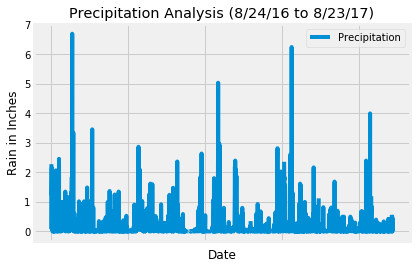

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()

locations

9

In [20]:
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# What is the most active station? (i.e. what station has the most rows)?
most_active_station = active_station[0][0]

most_active_station

'USC00519281'

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.round(func.avg(Measurement.tobs), 2)).filter(Measurement.station == most_active_station).all()

most_active_station_temperature_stats

[(54.0, 85.0, 71.66)]

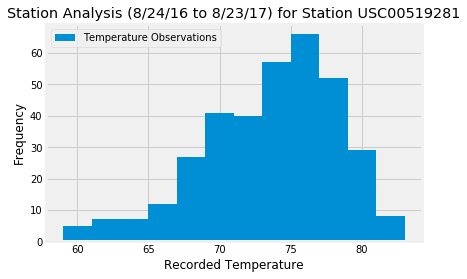

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date > date_one_year_ago).order_by(Measurement.date).all()

temperature_df=pd.DataFrame(temperature)
plt.hist(temperature_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active_station)
plt.legend(["Temperature Observations"])
plt.show()


In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs), 1), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.6, 74.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2016, 8, 24)

end_date = dt.date(2016, 9, 7)

date_one_year_ago = dt.timedelta(days=365)

average_temperature = calc_temps((start_date-date_one_year_ago), (end_date-date_one_year_ago))

average_temperature

[(72.0, 78.9, 86.0)]

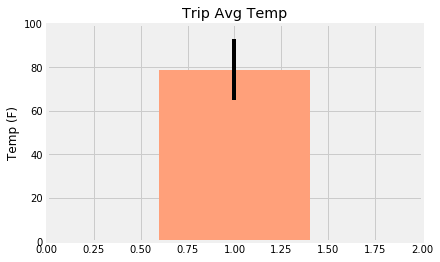

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = average_temperature[0][2]-average_temperature[0][0]
avg_temp = average_temperature[0][1]
min_temp = average_temperature[0][0]
max_temp = average_temperature[0][2]

plt.bar(1 , avg_temp, color="lightsalmon", yerr=peak_to_peak)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.ylim(0, 100)
plt.xlim(0,2)
plt.show()

In [49]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date_last_year = start_date - date_one_year_ago

end_date_last_year = end_date - date_one_year_ago

rainfall_station_data = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).filter(Measurement.date >= start_date_last_year).filter(Measurement.date <= end_date_last_year).filter(Measurement.station==Station.station).order_by((Measurement.prcp).desc()).all()

rainfall_station_data

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.67),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.29),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.55),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.35),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  1.3),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.16),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.04),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.03),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.97),
 ('USC00519523',
  